# REINFORCE with Discrete Actions

### 0. Background: Directly Modelling Optimal Policy

To address the larger continuous state spaces, we explored how to use a **neural network** to represent the **optimal action-value function**, which forms the basis of the **[Value Based Methods](../../../value-based/), such as Deep Q Learning algorithm**.

- In this case, the neural network takes the **state of the environment** as input and outputs the **value of each possible action**.
- For example, in the "CartPole" environment, the possible actions are:
  - Pushing the cart **to the left**.
  - Pushing the cart **to the right**.

Similar to the case of using a table, we can easily determine the **best action** for any given state by selecting the action that **maximizes the output values** of the neural network.

Whether we use a **table** (for small state spaces) or a **neural network** (for large state spaces), we must first **estimate the optimal action-value function** before solving for the **optimal policy**.

However, the question now arises: **Can we directly find the optimal policy without estimating the value function?**

The answer is **yes**, and we can achieve this through a class of algorithms known as **policy based method**. One of method is called **Reinforce**

#### Goal of DRL
Our goal is to find the values of the neural network weights $\theta$ that maximize the expected return $U(\theta)$:

$$
U(\theta) = \sum_{\tau} P(\tau; \theta) R(\tau)
$$

Where:
- $\tau$ is an arbitrary trajectory.
- $P(\tau; \theta)$ is the joint probability of the trajectory.
- $R(\tau)$ is the cumulative reward of the trajectory.

We optimize $\theta$ using **gradient ascent (similar to gradient descent but in opposite direction)**:
$$
\theta \leftarrow \theta + \alpha \nabla_\theta U(\theta)
$$


<div style="text-align: center;">
    <img src="./images/policy-gradient.png" alt="Mountain Car Environment" width="70%">
</div>

#### Algorithm Steps

1. **Collect trajectories**  
   Use the policy $\pi_\theta$ to collect $m$ trajectories:  
   $$
   \{\tau^{(1)}, \tau^{(2)}, \dots, \tau^{(m)}\}
   $$
   Each trajectory $\tau^{(i)}$ is defined as:
   $$
   \tau^{(i)} = (s_0^{(i)}, a_0^{(i)}, \dots, s_H^{(i)}, a_H^{(i)}, s_{H+1}^{(i)})
   $$
   Where $H$ is the trajectory horizon.

2. **Estimate the gradient**  
   Use the sampled trajectories to estimate the gradient $\nabla_\theta U(\theta)$:  
   $$
   \nabla_\theta U(\theta) \approx \hat{g} = \frac{1}{m} \sum_{i=1}^m \sum_{t=0}^H \nabla_\theta \log \pi_\theta(a_t^{(i)} \mid s_t^{(i)}) R(\tau^{(i)})
   $$

3. **Update the policy parameters**  
   Update the policy parameters using the gradient $\hat{g}$:
   $$
   \theta \leftarrow \theta + \alpha \hat{g}
   $$

4. **Repeat steps 1-3** until convergence.


#### Formula Explanation

- **Trajectory Probability**:  
  $$
  P(\tau; \theta) = P(s_0) \prod_{t=0}^H \pi_\theta(a_t \mid s_t) P(s_{t+1} \mid s_t, a_t)
  $$

- **Gradient Estimation**:  
  $$
  \nabla_\theta U(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a \mid s) R(\tau) \right]
  $$

- **Cumulative Reward (suppose discount is 1)**:  
  $$
  R(\tau) = \sum_{t=0}^H r(s_t, a_t)
  $$

---


#### Summary

- **Core Idea**: Directly optimize the policy parameters $\theta$ to maximize the expected cumulative reward.
- **Advantages**: Simple and easy to implement, applicable to both discrete and continuous action spaces.
- **Disadvantages**: High variance in gradient estimates, leading to low training efficiency.


In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# for game rendering
import time
from PIL import Image
from IPython import display

torch.manual_seed(0) # set random seed
gym.logger.min_level = 40
%matplotlib inline

### 2. Define the Architecture of the Policy

In [18]:
env = gym.make('CartPole-v0')

print('observation space:\n', env.observation_space)
print('action space:\n', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space:
 Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space:
 Discrete(2)


### 3. Train the Agent with REINFORCE

In [25]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)


def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, window=100):
    scores_window = deque(maxlen=window)

    scores = []
    for i_episode in range(1, n_episodes + 1):
        log_probs = []
        rewards = []
        state, _ = env.reset()
        for t in range(max_t):
            action, log_prob = policy.select_action(state)
            state, reward, done, _, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break

        discounts = torch.tensor(gamma**np.arange(len(rewards)), dtype=torch.float)
        rewards = torch.tensor(rewards, dtype=torch.float)
        R = discounts.dot(rewards)

        log_probs = torch.cat(log_probs)
        log_likelihood = log_probs.sum()
        loss = -log_likelihood * R

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scores.append(sum(rewards))
        scores_window.append(sum(rewards))

        avg_score = np.mean(scores_window)
        if i_episode % window == 0:
            print(f"Episode {i_episode}\tAverage Score: {avg_score:.2f}")

        if avg_score >= 195.0:
            print(
                f"Environment solved in {i_episode-window:d} episodes!\tAverage Score: {avg_score:.2f}"
            )
            break

    return scores


scores = reinforce(n_episodes=1000, max_t=1000, gamma=1.0, window=100)

Episode 100	Average Score: 31.11
Episode 200	Average Score: 52.79
Episode 300	Average Score: 142.20
Environment solved in 269 episodes!	Average Score: 195.23


### 4. Plot the Scores

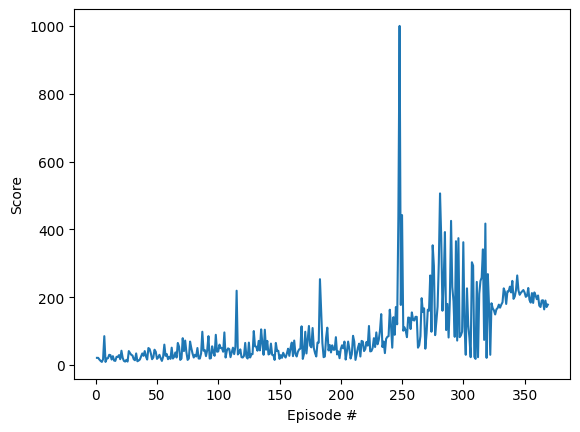

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

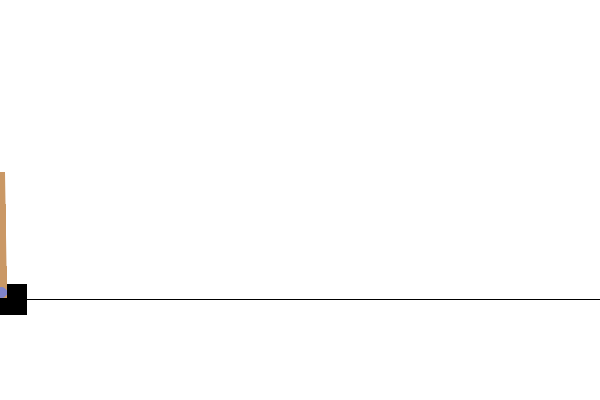

In [30]:
env = gym.make("CartPole-v0", render_mode="rgb_array")

state, _ = env.reset()
for t in range(1000):
    # clear frame
    display.clear_output(wait=True)

    action, _ = policy.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.05)

    state, reward, done, _, _ = env.step(action)
    if done:
        break 

env.close()

### Discussion
What are the main problems of REINFORCE? There are three issues:

- The update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

- The gradient estimate $g$ is very noisy. By chance the collected trajectory may not be representative of the policy.

- There is no clear credit assignment. A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.